## EDA Proyecto Oil & Gas 

Por cuestiones de practica, se hace una simulacion de carga de datos a una base de datos en sqlite para poder simular un entorno real de trabajo y hacer conslutas atravez de queries en SQL. 

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#importar utils para el EDA
import sys
import os

sys.path.append(os.path.abspath(".."))
from utils.plot_tools import auditoria_de_datos, diagnostico_auditoria, transformacion_log, graficar_variables_estrategicas

# Conexión a la Base de Datos
# Usamos 'industria.db' y pedimos TODO para ver qué tenemos
conn = sqlite3.connect("../data/industria.db") # Los .. son para salir de la carpeta notebooks

# Query de Ingesta de datos
query = """
SELECT *
FROM pipelines
"""

df = pd.read_sql(query, conn)
conn.close()

# Verificacion de carga 
print(f"Filas cargadas: {df.shape[0]}")
print(f"Columnas: {list(df.columns)}")
df.head()

Filas cargadas: 1000
Columnas: ['Pipe_Size_mm', 'Thickness_mm', 'Material', 'Grade', 'Max_Pressure_psi', 'Temperature_C', 'Corrosion_Impact_Percent', 'Thickness_Loss_mm', 'Material_Loss_Percent', 'Time_Years', 'Condition']


,Pipe_Size_mm,Thickness_mm,Material,Grade,Max_Pressure_psi,Temperature_C,Corrosion_Impact_Percent,Thickness_Loss_mm,Material_Loss_Percent,Time_Years,Condition
0,800,15.48,Carbon Steel,ASTM A333 Grade 6,300,84.9,16.04,4.91,31.72,2,Moderate
1,800,22.00,PVC,ASTM A106 Grade B,150,14.1,7.38,7.32,33.27,4,Critical
2,400,12.05,Carbon Steel,API 5L X52,2500,0.6,2.12,6.32,52.45,7,Critical
3,1500,38.72,Carbon Steel,API 5L X42,1500,52.7,5.58,6.20,16.01,19,Critical
4,1500,24.32,HDPE,API 5L X65,1500,11.7,12.29,8.58,35.28,20,Critical


### **Resumen del conjunto de datos**

Este conjunto de datos contiene 1.000 muestras de datos de oleoductos recogidos de la industria del petróleo y gas, destinados a su uso en modelado predictivo de mantenimiento. Cada registro representa datos de sensores y operativos procedentes de las tuberías, con etiquetas correspondientes que indican si se requería mantenimiento.

El objetivo es desarrollar modelos que puedan predecir posibles fallos o necesidades de mantenimiento antes de que ocurran, garantizando la seguridad de los oleoductos, reduciendo los tiempos de inactividad y minimizando los costes operativos.

### **Características de datos**
Cada fila del conjunto de datos corresponde a un segmento o instancia específica de la tubería e incluye lo siguiente:

**Pipe Size/Tamaño de la tubería:** Diámetro de la tubería

**Thickness/Grosor:** Espesor medido de la pared de la tubería

**Material:** Tipo de material utilizado (por ejemplo, acero, compuesto)

**Maximum Pressure/Presión máxima:** Presión máxima experimentada (psi)

**Temperature/Temperatura:** Temperatura interna del fluido (°C)

**Corrosion Impact Percentage/ Porcentaje de impacto por corrosión:** Nivel estimado de corrosión (%)

**Thickness Loss/Pérdida de grosor:** Pérdida de grosor de pared debido al desgaste o corrosión

**Material Loss Percentage/ Porcentaje de pérdida de materiales:** Porcentaje de la pérdida total de materiales

**Years Time/Años de tiempo:** Edad o tiempo de servicio (años)

**Condition/Condiciones:** Categoría de condición operativa (Normal, Moderada, Crítica)

**Maintenance Required (Objetivo):(*)** Etiqueta binaria (1 = mantenimiento necesario, 0 = sin mantenimiento)

__(*)__ El dataset original describe una columna objetivo __Maintenance_Required__, pero esta no está presente en el archivo CSV.
Para continuar con el objetivo del proyecto, se generó una etiqueta binaria basada en criterios de ingeniería (corrosión, pérdida de espesor y condición operativa)


Para crear la variable binaria __Maintenance Required__ (1 = mantenimiento necesario, 0 = no necesario) de forma realista y basada en criterios de ingeniería, se usan estándares como ASME B31G (y Modified B31G/RSTRENG para evaluación de resistencia remanente en tuberías corroídas), API 579-1/ASME FFS-1 (Fitness-for-Service para pérdida de material por corrosión general, localizada o pitting), ASME B31.4/B31.8 y prácticas de integridad de pipelines en oil & gas (PHMSA, NACE, etc.).

**Criterios clave de ingeniería**

* Pérdida de espesor (Thickness Loss / Remaining wall):
    * d/t (pérdida / espesor nominal) > 80% → crítico, requiere reparación inmediata (riesgo de perforación).
    * 50% nominal → suele requerir FFS detallado y posible reparación.
    * 20-30-40% → monitoreo intensivo o reparación si defectos largos; remaining < 70-80% del nominal/min requerido a menudo triggers acción.

* Tasa de corrosión (Corrosion Rate = Thickness_Loss_mm / Time_Years, en mm/año):
    * 0.5 mm/año → alta preocupación (depende del material/entorno); > 1 mm/año → urgente. Típicos umbrales de alerta: 0.1-0.125 mm/año (medio-alta), >0.4-0.5 mm/año alto riesgo.

* Condición operativa (Condition): "Critical" → mantenimiento casi siempre necesario (ya incorpora estrés operativo, presión/temperatura, etc.). "Moderate" → condicional según otros factores. "Normal" → generalmente 0, salvo pérdida severa.
    * Temperatura: > 60-80°C acelera corrosión (especialmente en acero al carbono); > 100°C con corrosión → alto riesgo.
    * Otros factores:
        * Corrosion_Impact_Percent o Material_Loss_Percent > 15-20% (impacto) o > 40-50% (pérdida material).
        * Tiempo en servicio (Time_Years > 15-20) con pérdida moderada.
        * Material: Carbon Steel más susceptible (corrosión externa/interna); Stainless/HDPE/PVC/Fiberglass tienen criterios diferentes (degradación química, pérdida de rating por presión, delaminación).
        * Presión: Si Max_Pressure_psi alto (>1000-1500 psi) con pérdida de espesor o tasa alta → mayor riesgo. No hay presión operativa real, así que usa Max como proxy de diseño.

In [2]:
#Creacion de nuevas variables para mejorar el modelo y crear el target
df['Thickness_Loss_mm'] = df['Thickness_Loss_mm'].clip(upper=df['Thickness_mm'])  # cap a 100% pérdida
df['Remaining_Percent'] = 100 * (df['Thickness_mm'] - df['Thickness_Loss_mm']) / df['Thickness_mm'].replace(0, np.nan)
df['Corrosion_Rate_mm_y'] = df['Thickness_Loss_mm'] / df['Time_Years'].replace(0, 1)  # evita /0
df['Loss_Pct'] = 100 * df['Thickness_Loss_mm'] / df['Thickness_mm'].replace(0, np.nan)

In [3]:
#Creacion de Target Maintenance_Required
df['Maintenance_Required'] = 0

# 1. Condición operativa crítica
crit1 = (df['Condition'] == 'Critical')

# 2. Pérdida severa de espesor (conservador ~30-50%, cerca de API/B31G)
crit2 = (df['Loss_Pct'] > 40) | (df['Remaining_Percent'] < 60)

# 3. Tasa de corrosión alta
crit3 = df['Corrosion_Rate_mm_y'] > 0.5

# 4. Temperatura alta + corrosión
crit4 = (df['Temperature_C'] > 80) & ((df['Corrosion_Impact_Percent'] > 12) | (df['Loss_Pct'] > 20))

# 5. Pérdida material alta o impacto
crit5 = (df['Material_Loss_Percent'] > 50) | (df['Corrosion_Impact_Percent'] > 20)

# 6. Tiempo largo + degradación moderada (predicción futura)
crit6 = (df['Time_Years'] > 15) & ((df['Loss_Pct'] > 25) | (df['Condition'] == 'Moderate'))

# 7. Material sensible + pérdida moderada (Carbon Steel más crítico)
crit7 = df['Material'].isin(['Carbon Steel']) & (df['Loss_Pct'] > 30)

# 8. Presión alta + degradación (proxy)
crit8 = (df['Max_Pressure_psi'] > 1200) & ((df['Loss_Pct'] > 20) | (df['Corrosion_Rate_mm_y'] > 0.3))

df['Maintenance_Required'] = np.where(crit1 | crit2 | crit3 | crit4 | crit5 | crit6 | crit7 | crit8, 1, 0)
df['Maintenance_Required'] = df['Maintenance_Required'].astype(bool)

In [4]:
reporte = auditoria_de_datos(df)
reporte

Informacion del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pipe_Size_mm              1000 non-null   int64  
 1   Thickness_mm              1000 non-null   float64
 2   Material                  1000 non-null   object 
 3   Grade                     1000 non-null   object 
 4   Max_Pressure_psi          1000 non-null   int64  
 5   Temperature_C             1000 non-null   float64
 6   Corrosion_Impact_Percent  1000 non-null   float64
 7   Thickness_Loss_mm         1000 non-null   float64
 8   Material_Loss_Percent     1000 non-null   float64
 9   Time_Years                1000 non-null   int64  
 10  Condition                 1000 non-null   object 
 11  Remaining_Percent         1000 non-null   float64
 12  Corrosion_Rate_mm_y       1000 non-null   float64
 13  Loss_Pct                  1000 non-null

,mean,median,std,min,max,cv,skew,kurtosis,outliers,variance
Pipe_Size_mm,522.000000,300.000000,443.703587,50.000000,1500.00000,85.000671,0.909715,-0.385009,0.0,196872.872873
Thickness_mm,16.073530,12.930000,10.548358,3.000000,49.53000,65.625238,0.933389,0.104414,1.1,111.267854
Max_Pressure_psi,1004.100000,900.000000,812.843099,150.000000,2500.00000,80.952397,0.803780,-0.668937,0.0,660713.903904
Temperature_C,42.595600,41.200000,41.127071,-50.000000,149.70000,96.552166,0.269018,-0.258605,0.0,1691.435977
Corrosion_Impact_Percent,9.745990,9.720000,5.817492,0.000000,20.00000,59.690518,0.054038,-1.231404,0.0,33.843208
Thickness_Loss_mm,4.618400,4.640000,2.722686,0.010000,9.99000,58.951730,0.079749,-1.046428,0.0,7.413017
Material_Loss_Percent,46.747560,31.660000,46.602553,0.080000,318.75000,99.689596,1.943946,4.648783,7.0,2171.797961
Time_Years,12.961000,13.000000,7.135993,1.000000,25.00000,55.057004,-0.022498,-1.183413,0.0,50.922401
Remaining_Percent,59.056740,68.342564,31.726887,0.000000,99.92278,53.722629,-0.687332,-0.766037,0.0,1006.595353
Corrosion_Rate_mm_y,0.703711,0.355307,1.131624,0.000476,9.75000,160.785163,4.086554,21.097302,10.9,1.280573


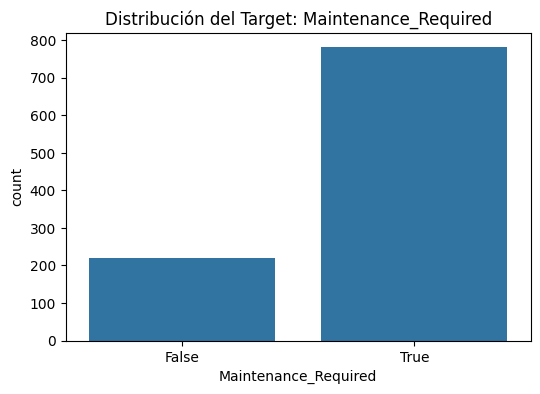

In [5]:
#Grafico del Target 
plt.figure(figsize=(6,4))
sns.countplot(x="Maintenance_Required", data=df)
plt.title("Distribución del Target: Maintenance_Required")
plt.show()

In [6]:
resultados = diagnostico_auditoria(df, reporte)
resultados

,Variable,Tipo,Estado,Acción Recomendada,Prioridad
0,Pipe_Size_mm,Numérica,"Muy Sesgada, Media alejada de Mediana",Graficar Histograma + Aplicar Log/PowerTransfo...,Alta
1,Thickness_mm,Numérica,"Muy Sesgada, Media alejada de Mediana",Graficar Histograma + Aplicar Log/PowerTransfo...,Alta
2,Material_Loss_Percent,Numérica,"Muy Sesgada, Muchos Outliers, Media alejada de...",Graficar Histograma + Graficar Boxplot + Inves...,Alta
3,Corrosion_Rate_mm_y,Numérica,"Muy Sesgada, Muy Volátil (CV=161%), Muchos Out...",Graficar Histograma + Graficar Boxplot + Inves...,Alta
4,Condition,Categórica,Desbalanceada,Graficar Countplot,Alta
5,Max_Pressure_psi,Numérica,"Leve Sesgo, Media alejada de Mediana",Graficar Histograma (Verificar),Media
6,Temperature_C,Numérica,Normal,Graficar Histograma (Verificar),Media
7,Corrosion_Impact_Percent,Numérica,Normal,Graficar Histograma (Verificar),Media
8,Thickness_Loss_mm,Numérica,Normal,Graficar Histograma (Verificar),Media
9,Time_Years,Numérica,Normal,Graficar Histograma (Verificar),Media


Generando gráficos para 14 variables relevantes...



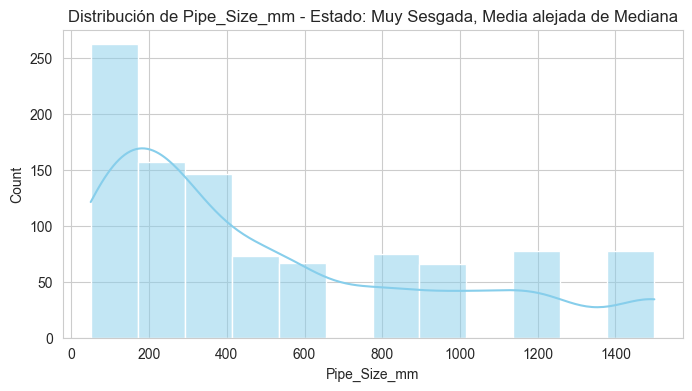

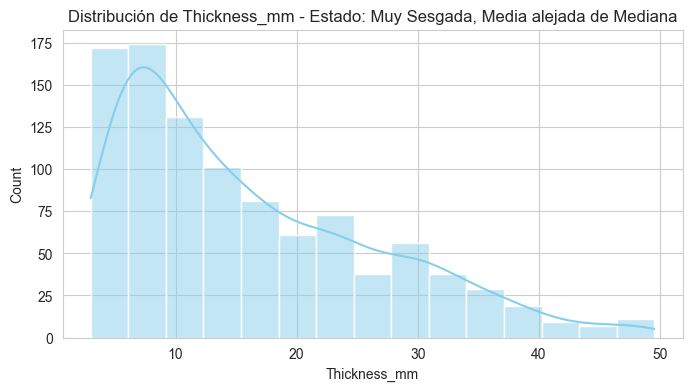

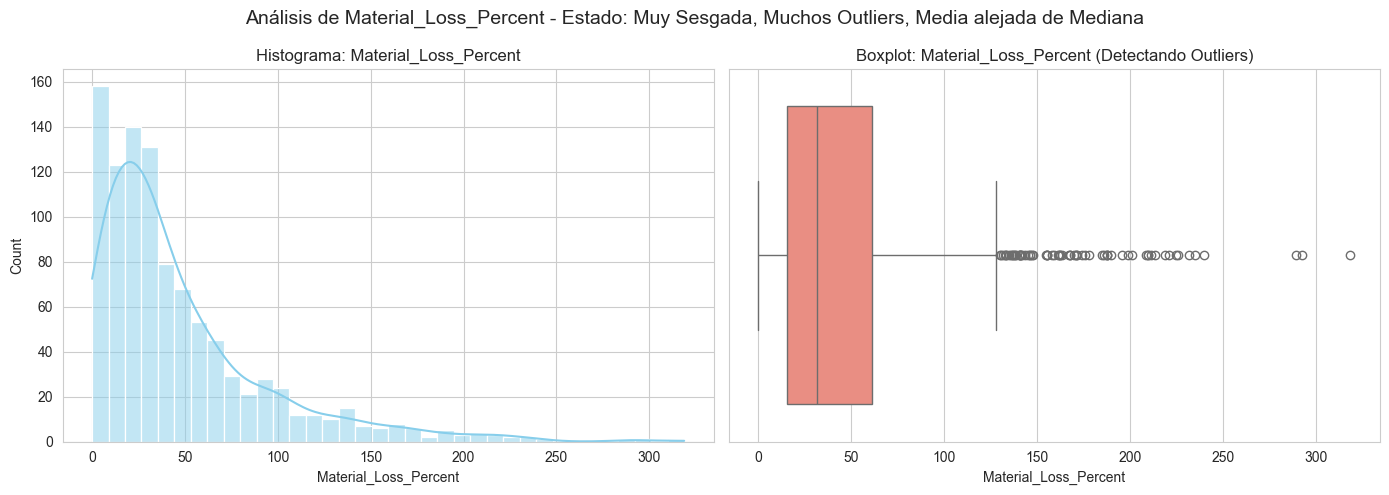

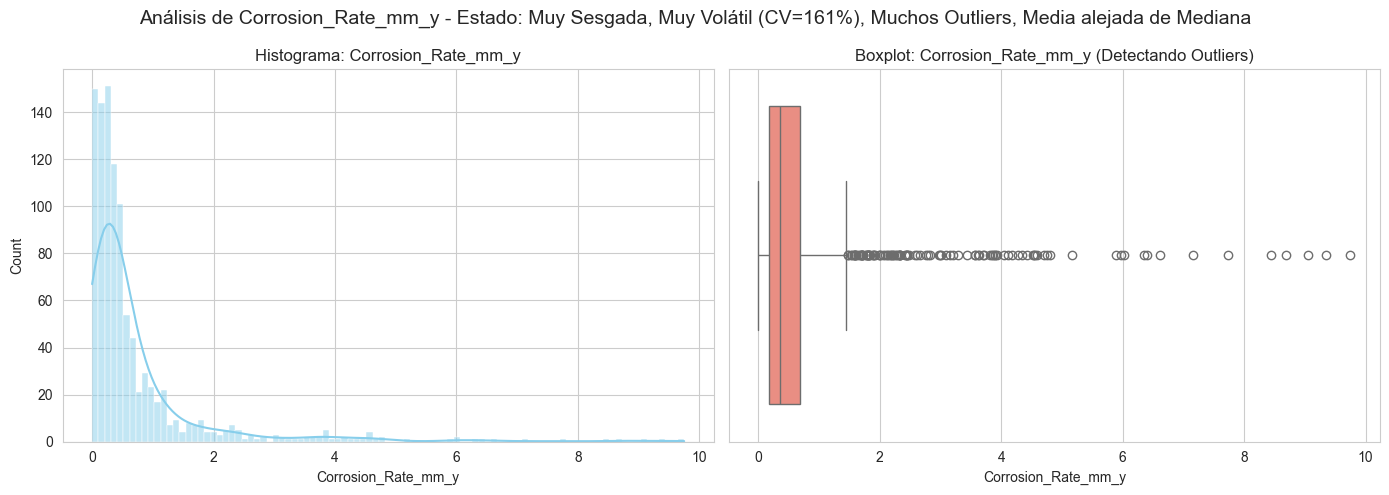

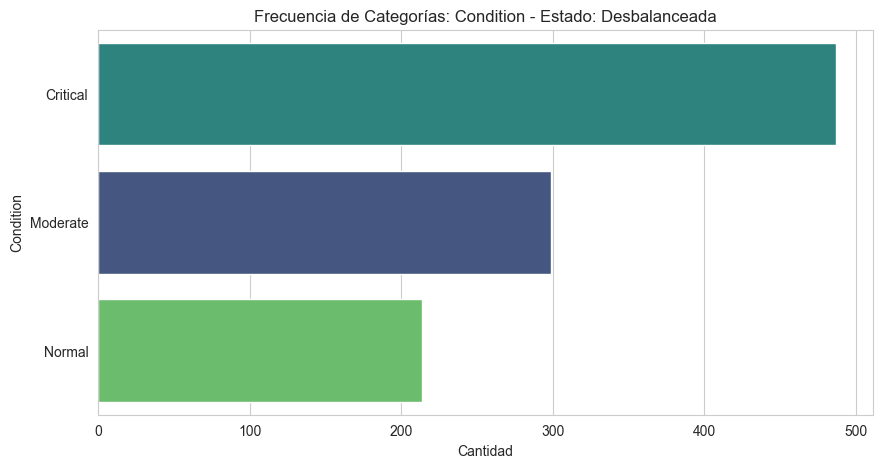

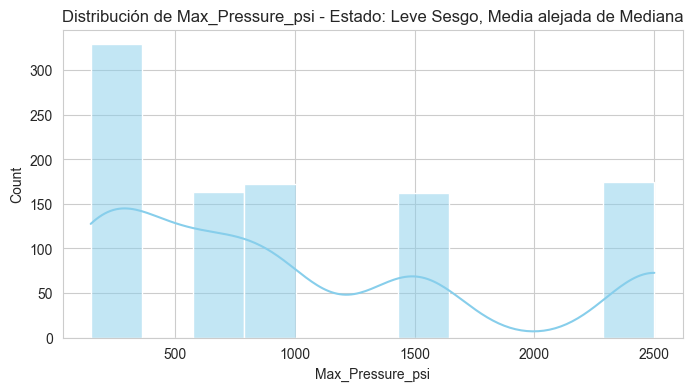

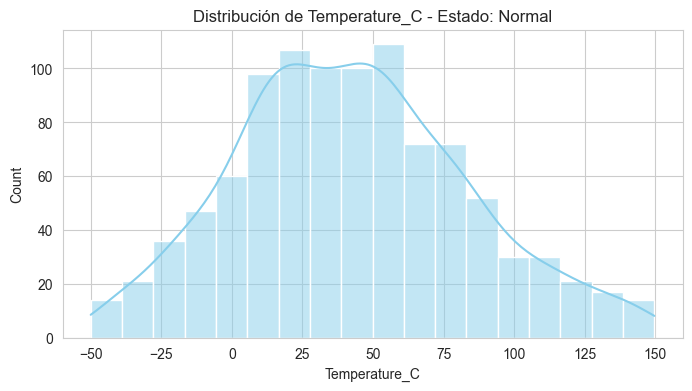

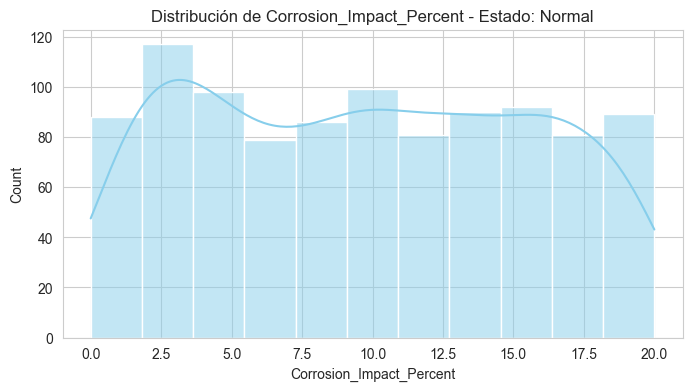

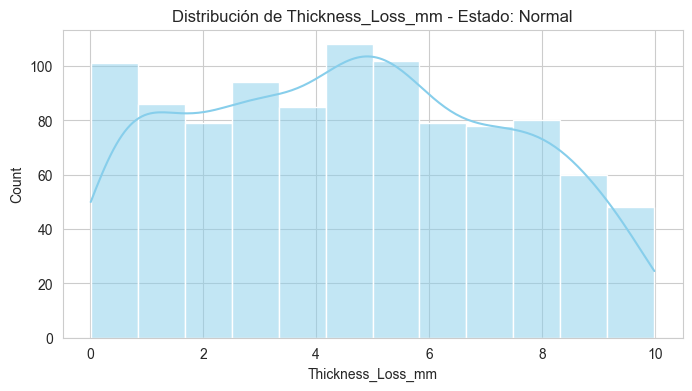

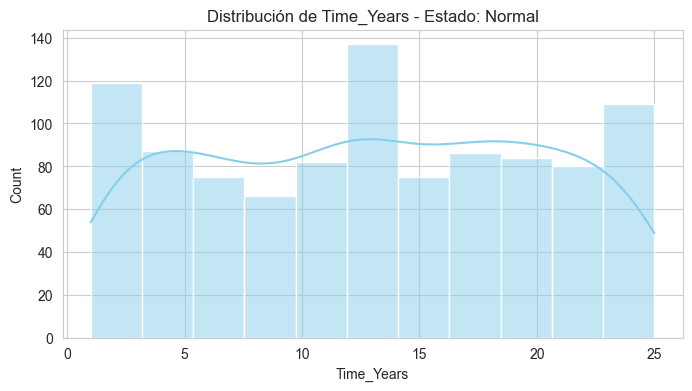

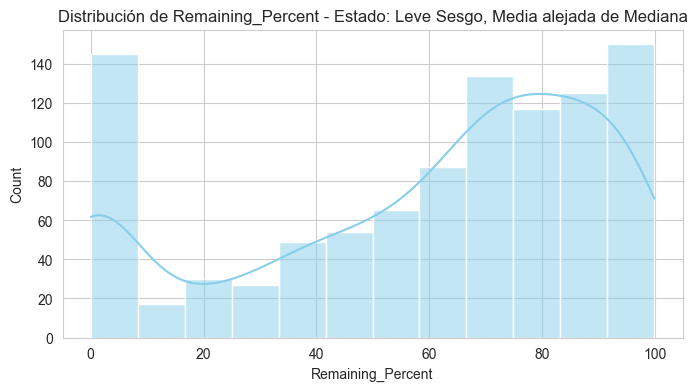

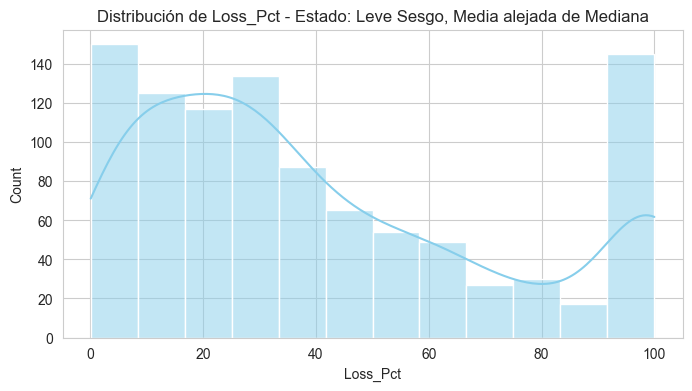

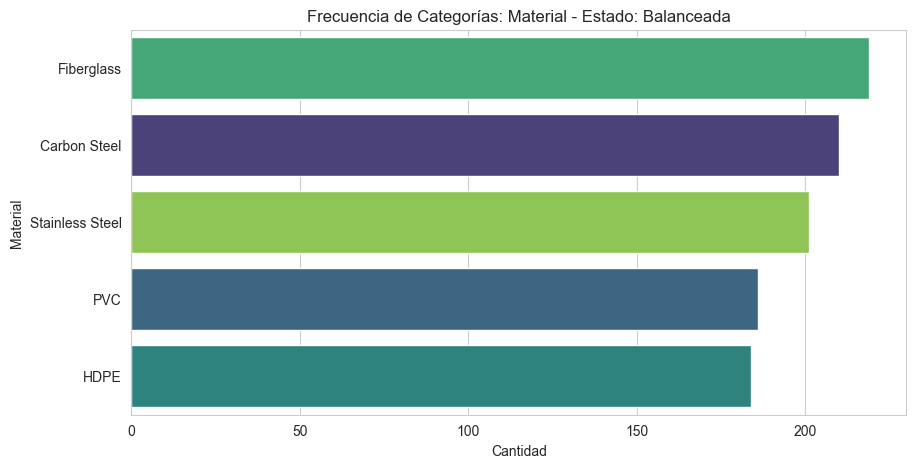

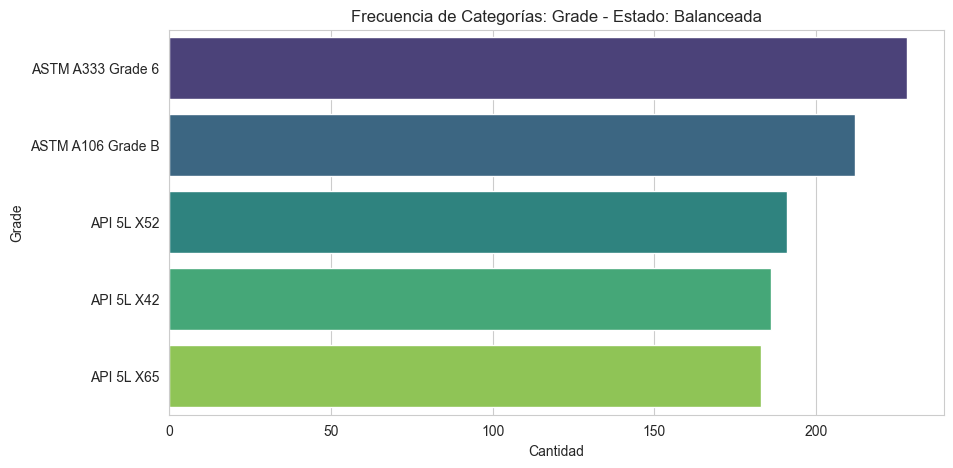

Generación de gráficos finalizada.


In [7]:
graficos = graficar_variables_estrategicas(df, resultados)

Transformaciones y tratamiento de las variables: se les va aplicar *log1p* con _*transformacion_log()* , (o la transformacion que corresponda) para ver si es factible normalizar las variables o si se usa algun otro metodo.

__Variables  Muy Sesgada / Muy Volátil / Outliers__
- Pipe_Size_mm
- Thickness_mm
- Material_Loss_Percent
- Corrosion_Rate_mm_y

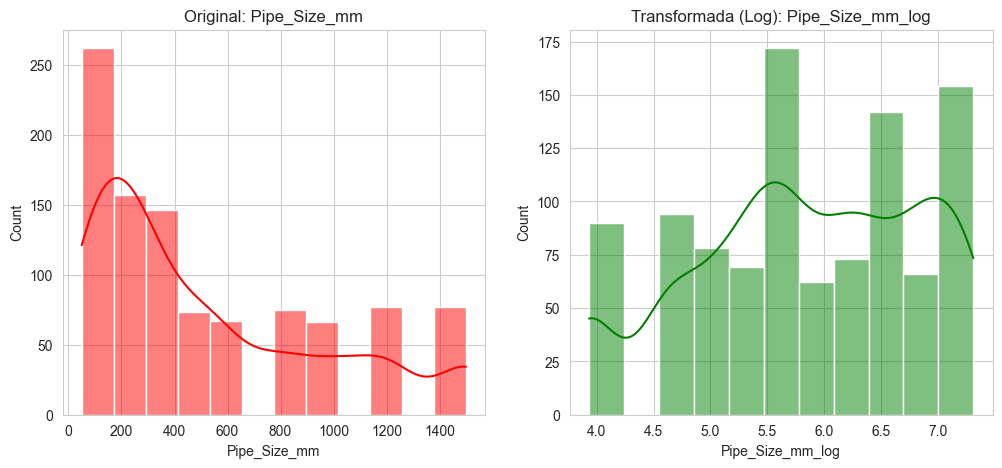

Skew Original: 0.91
Skew Log: -0.29
Kurtosis Original: -0.39
Kurtosis Log: -0.88
CV Original: 0.85
CV Log: 0.17


In [8]:
transformacion_log(df, "Pipe_Size_mm")

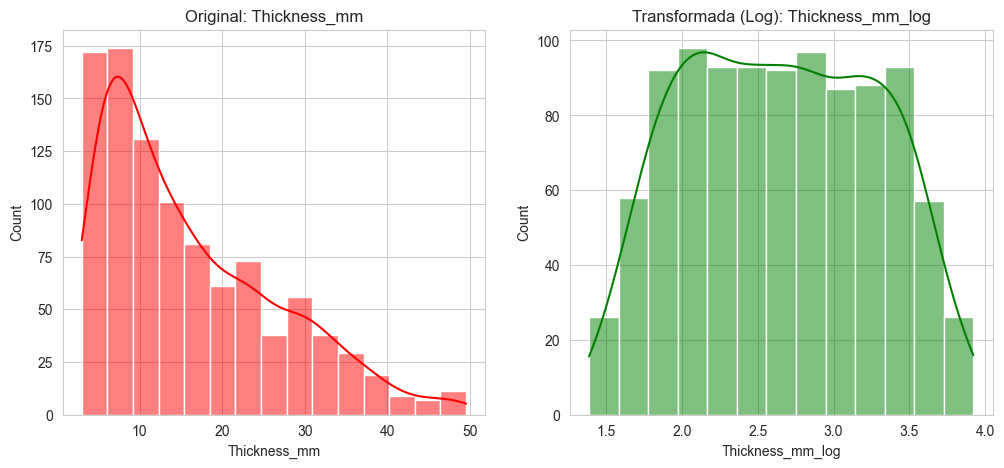

Skew Original: 0.93
Skew Log: 0.03
Kurtosis Original: 0.10
Kurtosis Log: -1.04
CV Original: 0.66
CV Log: 0.24


In [9]:
transformacion_log(df, "Thickness_mm")

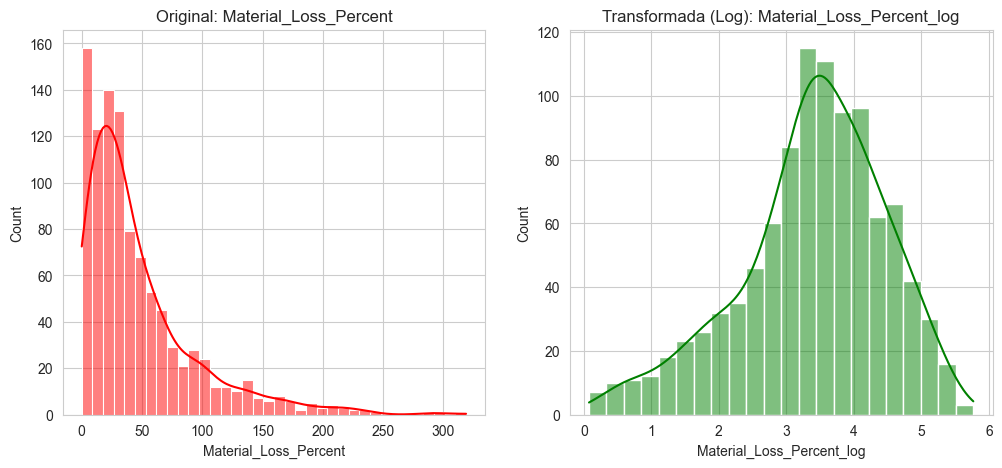

Skew Original: 1.94
Skew Log: -0.59
Kurtosis Original: 4.65
Kurtosis Log: 0.18
CV Original: 1.00
CV Log: 0.32


In [10]:
transformacion_log(df, "Material_Loss_Percent")

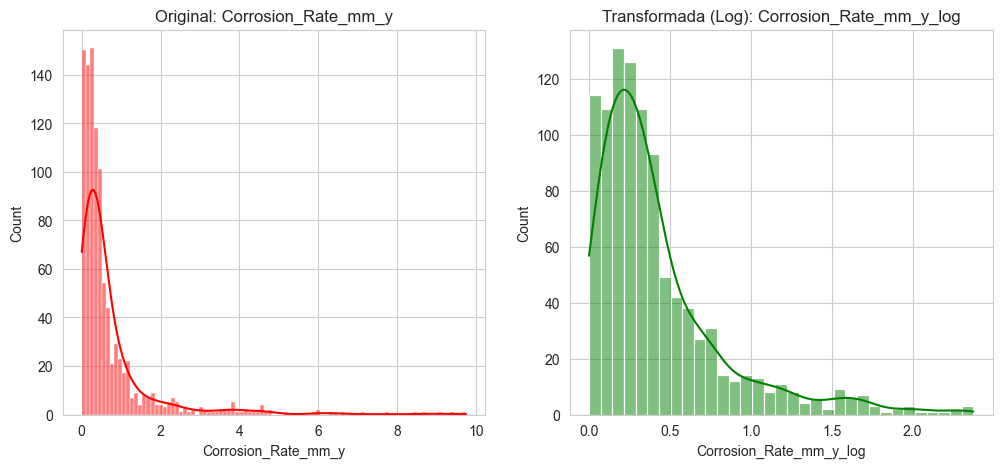

Skew Original: 4.09
Skew Log: 1.99
Kurtosis Original: 21.10
Kurtosis Log: 4.45
CV Original: 1.61
CV Log: 0.96


In [11]:
transformacion_log(df,"Corrosion_Rate_mm_y")

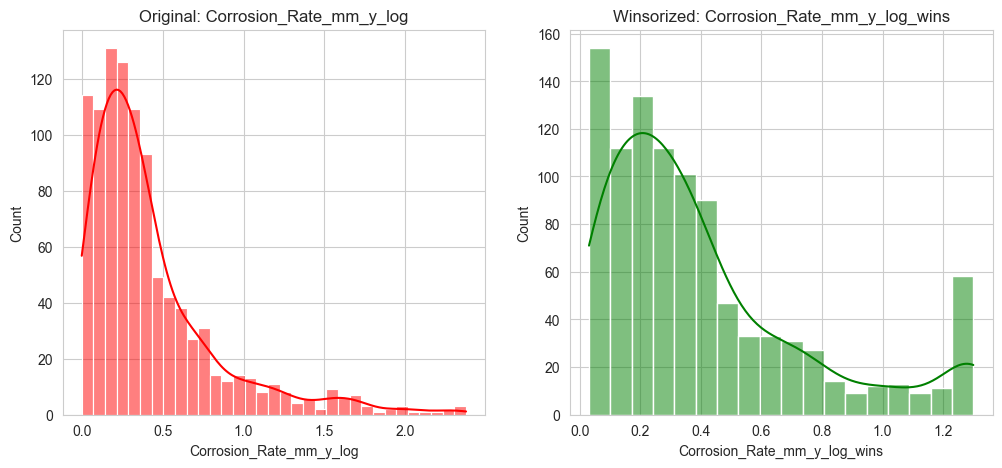

Skew Original: 1.99
Skew Log_Wins: 1.29
Kurtosis Original: 4.45
Kurtosis Log_Wins: 0.90
CV Original: 0.96
CV Log_Wins: 0.84


In [12]:
#A la variable Corrosion_Rate_mm_y se le plico log1p pero no fue sufieciente para normalizar su distribucion.
#Solucion: aplicar Winsorizacion (Winssorizing) para limitar valores extemos.

#Winsorizing se aplica después del log porque el log ya comprimió los valores extremos y hace que el recorte sea más preciso y menos destructivo.
lower = df["Corrosion_Rate_mm_y_log"].quantile(0.05)
upper = df["Corrosion_Rate_mm_y_log"].quantile(0.95)

df["Corrosion_Rate_mm_y_log_wins"] = np.clip(
    df["Corrosion_Rate_mm_y_log"],
    lower,
    upper
)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df["Corrosion_Rate_mm_y_log"], kde=True, ax=ax[0], color='red')
ax[0].set_title("Original: Corrosion_Rate_mm_y_log")

sns.histplot(df["Corrosion_Rate_mm_y_log_wins"], kde=True, ax=ax[1], color='green')
ax[1].set_title("Winsorized: Corrosion_Rate_mm_y_log_wins")

plt.show()
    
# Métricas
skew_orig = df["Corrosion_Rate_mm_y_log"].skew()
skew_log = df["Corrosion_Rate_mm_y_log_wins"].skew()

kurt_orig = df["Corrosion_Rate_mm_y_log"].kurt()
kurt_log = df["Corrosion_Rate_mm_y_log_wins"].kurt()

cv_orig = df["Corrosion_Rate_mm_y_log"].std() / df["Corrosion_Rate_mm_y_log"].mean()
cv_log = df["Corrosion_Rate_mm_y_log_wins"].std() / df["Corrosion_Rate_mm_y_log_wins"].mean()

print(f"Skew Original: {skew_orig:.2f}")
print(f"Skew Log_Wins: {skew_log:.2f}")
print(f"Kurtosis Original: {kurt_orig:.2f}")
print(f"Kurtosis Log_Wins: {kurt_log:.2f}")
print(f"CV Original: {cv_orig:.2f}")
print(f"CV Log_Wins: {cv_log:.2f}")

Como los modelos no necesitan simetría perfecta.

Aún asimétrica, pero mucho más razonable para ML.
Una kurtosis cercana a 0 indica que la cola ya no es problemática.

Con skew ≈ 1.2 y kurtosis < 1, la variable está lista para usar.


## **Leve Sesgo**
- Max_Pressure_psi  
- Remaining_Percent 
- Loss_Pct  

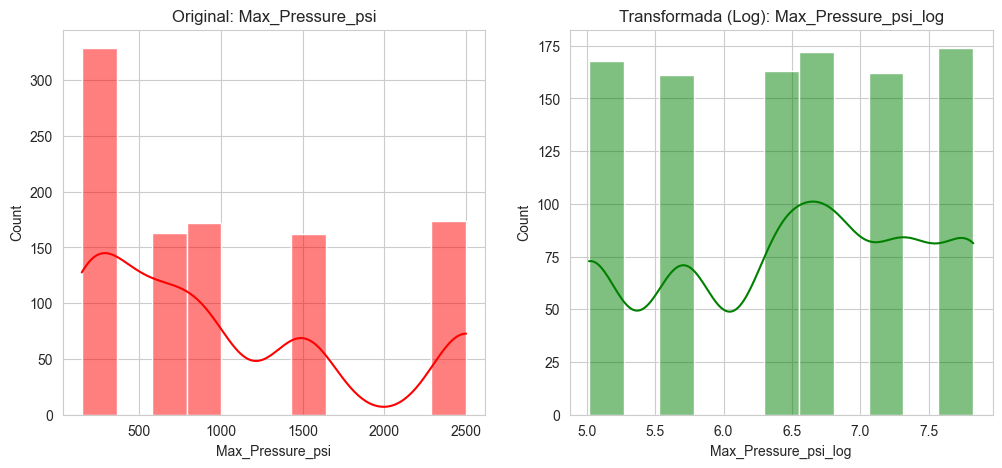

Skew Original: 0.80
Skew Log: -0.22
Kurtosis Original: -0.67
Kurtosis Log: -1.15
CV Original: 0.81
CV Log: 0.15


In [13]:
transformacion_log(df,"Max_Pressure_psi")

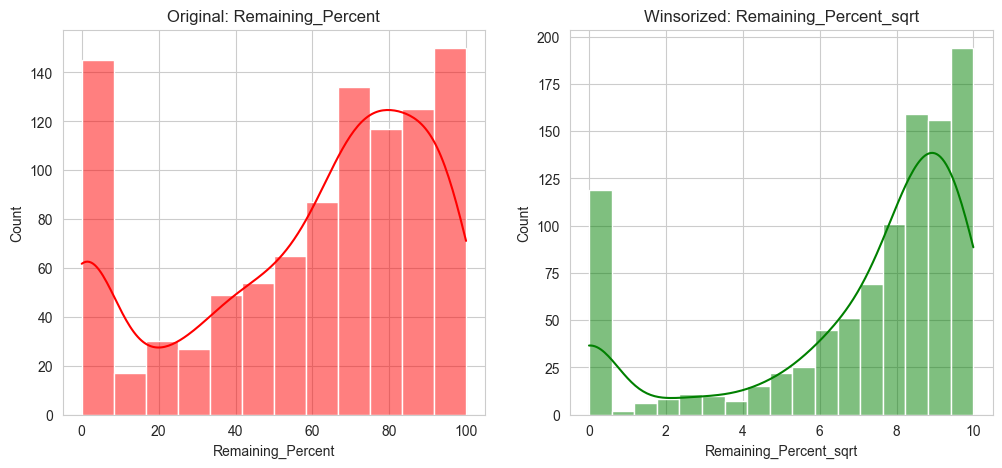

Skew Original: -0.69
Skew Sqrt: -1.35
Kurtosis Original: -0.77
Kurtosis Sqrt: 0.54
CV Original: 0.54
CV Sqrt: 0.44


In [14]:
""" 
Como la distribucion tiene 
    - Skew: –0.69 → leve asimetría a la izquierda
    - Kurtosis: –0.77 → colas livianas
    - CV: 0.54 → variabilidad moderada
Es una variable bastante sana, entoces voy a probar con una transformacion sqrt mas suave
"""

df["Remaining_Percent_sqrt"] = np.sqrt(df["Remaining_Percent"])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df["Remaining_Percent"], kde=True, ax=ax[0], color='red')
ax[0].set_title("Original: Remaining_Percent")

sns.histplot(df["Remaining_Percent_sqrt"], kde=True, ax=ax[1], color='green')
ax[1].set_title("Winsorized: Remaining_Percent_sqrt")

plt.show()
    
# Métricas
skew_orig = df["Remaining_Percent"].skew()
skew_log = df["Remaining_Percent_sqrt"].skew()

kurt_orig = df["Remaining_Percent"].kurt()
kurt_log = df["Remaining_Percent_sqrt"].kurt()

cv_orig = df["Remaining_Percent"].std() / df["Remaining_Percent"].mean()
cv_log = df["Remaining_Percent_sqrt"].std() / df["Remaining_Percent_sqrt"].mean()

print(f"Skew Original: {skew_orig:.2f}")
print(f"Skew Sqrt: {skew_log:.2f}")
print(f"Kurtosis Original: {kurt_orig:.2f}")
print(f"Kurtosis Sqrt: {kurt_log:.2f}")
print(f"CV Original: {cv_orig:.2f}")
print(f"CV Sqrt: {cv_log:.2f}")

En este caso la este caso las transformaciones (log1p y sqtr) no muestran mejoria, asique, se opta por dejar la variable sin transformar ya que el sesgo es muy leve, y no representaria un problema para el modelado

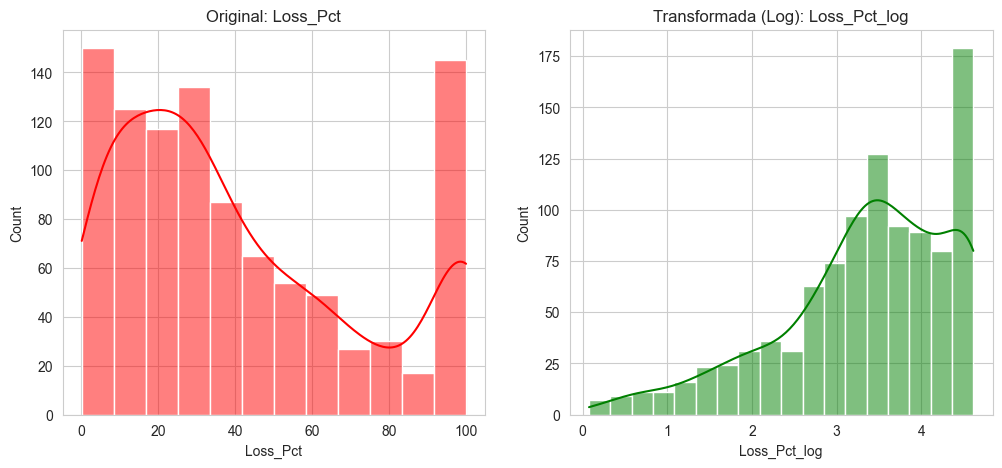

Skew Original: 0.69
Skew Log: -0.86
Kurtosis Original: -0.77
Kurtosis Log: 0.30
CV Original: 0.77
CV Log: 0.31


In [15]:
transformacion_log(df,"Loss_Pct")

In [16]:
# Mostrar nuevamente el df 
df.head()
# Nuevas estadisticas descriptivas (comparacion de variables transformadas con las originales)
describe = auditoria_de_datos(df)
describe

Informacion del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Pipe_Size_mm                  1000 non-null   int64  
 1   Thickness_mm                  1000 non-null   float64
 2   Material                      1000 non-null   object 
 3   Grade                         1000 non-null   object 
 4   Max_Pressure_psi              1000 non-null   int64  
 5   Temperature_C                 1000 non-null   float64
 6   Corrosion_Impact_Percent      1000 non-null   float64
 7   Thickness_Loss_mm             1000 non-null   float64
 8   Material_Loss_Percent         1000 non-null   float64
 9   Time_Years                    1000 non-null   int64  
 10  Condition                     1000 non-null   object 
 11  Remaining_Percent             1000 non-null   float64
 12  Corrosion_Rate_mm_y           1000 non

,mean,median,std,min,max,cv,skew,kurtosis,outliers,variance
Pipe_Size_mm,522.000000,300.000000,443.703587,50.000000,1500.000000,85.000671,0.909715,-0.385009,0.0,196872.872873
Thickness_mm,16.073530,12.930000,10.548358,3.000000,49.530000,65.625238,0.933389,0.104414,1.1,111.267854
Max_Pressure_psi,1004.100000,900.000000,812.843099,150.000000,2500.000000,80.952397,0.803780,-0.668937,0.0,660713.903904
Temperature_C,42.595600,41.200000,41.127071,-50.000000,149.700000,96.552166,0.269018,-0.258605,0.0,1691.435977
Corrosion_Impact_Percent,9.745990,9.720000,5.817492,0.000000,20.000000,59.690518,0.054038,-1.231404,0.0,33.843208
Thickness_Loss_mm,4.618400,4.640000,2.722686,0.010000,9.990000,58.951730,0.079749,-1.046428,0.0,7.413017
Material_Loss_Percent,46.747560,31.660000,46.602553,0.080000,318.750000,99.689596,1.943946,4.648783,7.0,2171.797961
Time_Years,12.961000,13.000000,7.135993,1.000000,25.000000,55.057004,-0.022498,-1.183413,0.0,50.922401
Remaining_Percent,59.056740,68.342564,31.726887,0.000000,99.922780,53.722629,-0.687332,-0.766037,0.0,1006.595353
Corrosion_Rate_mm_y,0.703711,0.355307,1.131624,0.000476,9.750000,160.785163,4.086554,21.097302,10.9,1.280573


In [17]:
#  ANÁLISIS DE CORRELACIONES Y RELACIÓN CON EL TARGET

from scipy.stats import spearmanr, pearsonr, chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# 1. Correlación con el TARGET (Maintenance_Required)

print("CORRELACIÓN CON EL TARGET (Maintenance_Required)")

# Separamos numéricas y categóricas
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Quitamos el target de las listas si estuviera
if 'Maintenance_Required' in numerical_cols:
    numerical_cols.remove('Maintenance_Required')
if 'Maintenance_Required' in categorical_cols:
    categorical_cols.remove('Maintenance_Required')

#Correlación con variables numéricas 
print("\nCorrelaciones con el target (Spearman):")
corr_target_num = []

for col in numerical_cols:
    # Spearman (no paramétrico, mejor con distribuciones no normales)
    corr, p_value = spearmanr(df[col], df['Maintenance_Required'])
    corr_target_num.append({
        'Variable': col,
        'Spearman_corr': round(corr, 4),
        'p-value': round(p_value, 6),
        'Significativo': 'Sí' if p_value < 0.05 else 'No'
    })

corr_target_df = pd.DataFrame(corr_target_num).sort_values('Spearman_corr', ascending=False)
display(corr_target_df.style.background_gradient(cmap='RdYlBu', subset=['Spearman_corr']))


# Relación con variables categóricas 
print("Relación con variables categóricas (Chi-cuadrado)")

cat_results = []

for col in categorical_cols:
    if col == 'Maintenance_Required':
        continue
    
    # Tabla de contingencia
    crosstab = pd.crosstab(df[col], df['Maintenance_Required'], normalize='index') * 100
    crosstab.columns = ['No Mantenimiento (%)', 'Sí Mantenimiento (%)']
    
    # Chi-cuadrado
    contingency = pd.crosstab(df[col], df['Maintenance_Required'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    
    # Mutual Information (necesita codificación numérica)
    le = LabelEncoder()
    mi_score = mutual_info_classif(
        le.fit_transform(df[col]).reshape(-1, 1),
        df['Maintenance_Required'],
        discrete_features=True
    )[0]
    
    cat_results.append({
        'Variable': col,
        'Chi2 p-value': round(p, 6),
        'Significativo': 'Sí' if p < 0.05 else 'No',
        'Mutual Info': round(mi_score, 4),
        'Tasa mantenimiento por categoría': crosstab.to_dict(orient='index')
    })

    print(f"\n{col}:")
    print(crosstab.round(2))
    print(f"Chi² p-value: {p:.6f} → {'Significativo' if p < 0.05 else 'No significativo'}")
    print(f"Mutual Information: {mi_score:.4f}")

# Tabla resumen categóricas
cat_summary = pd.DataFrame([{
    'Variable': r['Variable'],
    'Chi2 p-value': r['Chi2 p-value'],
    'Significativo': r['Significativo'],
    'Mutual Info': r['Mutual Info']
} for r in cat_results]).sort_values('Mutual Info', ascending=False)

print("\nResumen categóricas vs target:")
display(cat_summary.style.background_gradient(cmap='YlOrRd', subset=['Mutual Info']))




CORRELACIÓN CON EL TARGET (Maintenance_Required)

Correlaciones con el target (Spearman):


,Variable,Spearman_corr,p-value,Significativo
5,Thickness_Loss_mm,0.642700,0.000000,Sí
18,Loss_Pct_log,0.618000,0.000000,Sí
10,Loss_Pct,0.617900,0.000000,Sí
13,Material_Loss_Percent_log,0.617500,0.000000,Sí
6,Material_Loss_Percent,0.617500,0.000000,Sí
15,Corrosion_Rate_mm_y_log_wins,0.563600,0.000000,Sí
14,Corrosion_Rate_mm_y_log,0.563500,0.000000,Sí
9,Corrosion_Rate_mm_y,0.563500,0.000000,Sí
3,Temperature_C,0.058300,0.065280,No
4,Corrosion_Impact_Percent,0.044000,0.164429,No


Relación con variables categóricas (Chi-cuadrado)

Material:
                 No Mantenimiento (%)  Sí Mantenimiento (%)
Material                                                   
Carbon Steel                    26.19                 73.81
Fiberglass                      19.18                 80.82
HDPE                            22.83                 77.17
PVC                             19.89                 80.11
Stainless Steel                 21.39                 78.61
Chi² p-value: 0.438097 → No significativo
Mutual Information: 0.0019

Grade:
                   No Mantenimiento (%)  Sí Mantenimiento (%)
Grade                                                        
API 5L X42                        22.04                 77.96
API 5L X52                        16.75                 83.25
API 5L X65                        18.58                 81.42
ASTM A106 Grade B                 27.36                 72.64
ASTM A333 Grade 6                 23.68                 76.32
Chi² p-v

,Variable,Chi2 p-value,Significativo,Mutual Info
2,Condition,0.000000,Sí,0.283500
1,Grade,0.082613,No,0.004100
0,Material,0.438097,No,0.001900


MATRIZ DE CORRELACIONES (Spearman) - Variables Numéricas


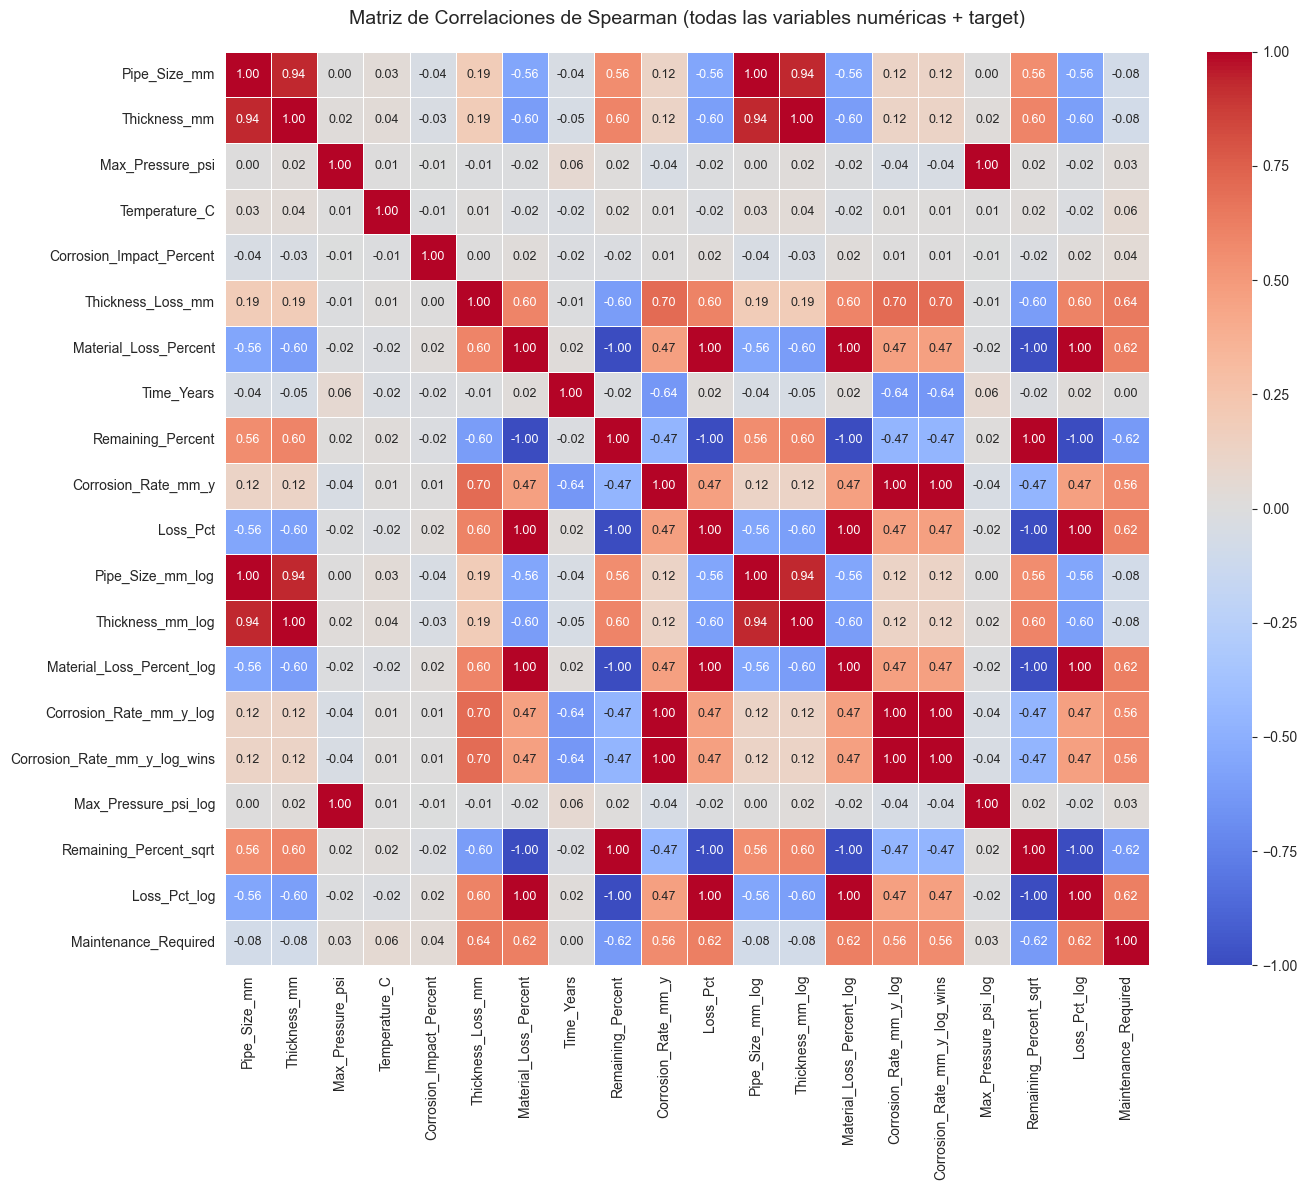

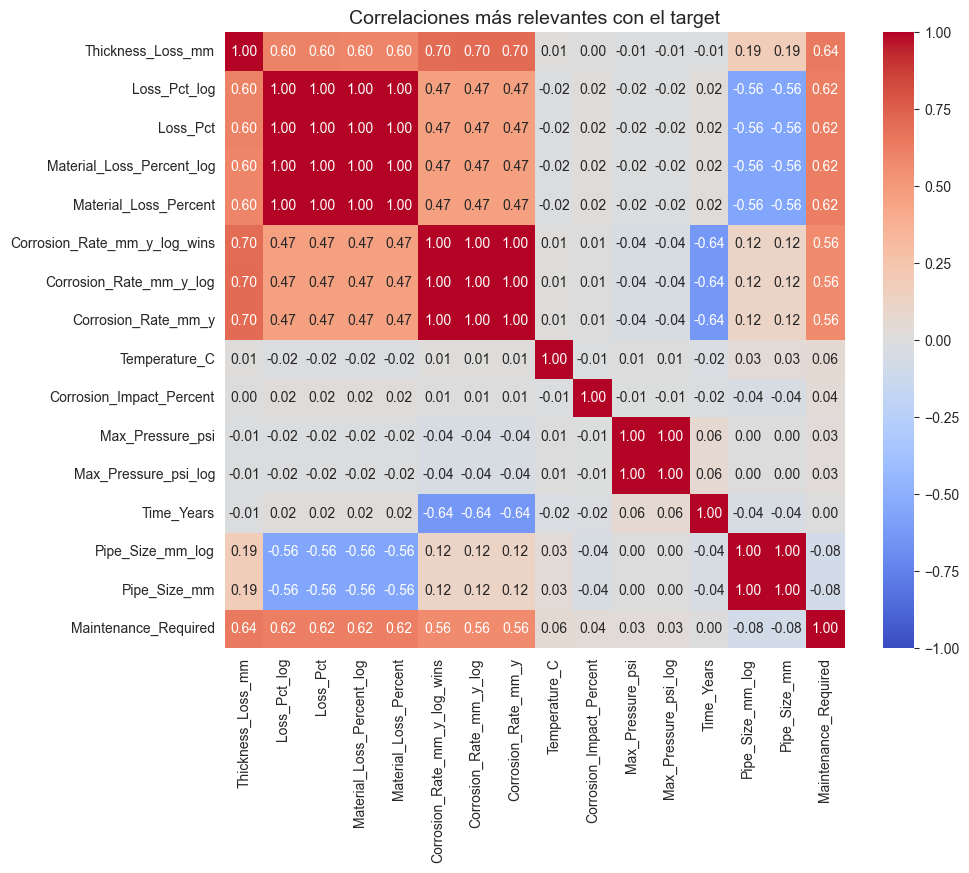

In [18]:
# Matriz de correlaciones entre variables numéricas (Heatmap)
print("MATRIZ DE CORRELACIONES (Spearman) - Variables Numéricas")

# Seleccionamos solo numéricas (incluimos el target para verlo también)
num_df = df[numerical_cols + ['Maintenance_Required']]

# Calculamos matriz Spearman
corr_matrix = num_df.corr(method='spearman')

# Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    center=0,
    linewidths=0.5,
    annot_kws={"size": 9}
)
plt.title("Matriz de Correlaciones de Spearman (todas las variables numéricas + target)", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Variables más correlacionadas con el target (top 15)
top_features = corr_target_df.head(15)['Variable'].tolist() + ['Maintenance_Required']
corr_top = df[top_features].corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_top, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlaciones más relevantes con el target", fontsize=14)
plt.show()

## Conclusiones finales del EDA

El análisis de correlaciones revela que las variables más predictivas de `Maintenance_Required` son:
- `Thickness_Loss_mm` (Spearman = 0.643)
-  `Loss_Pct_log` (0.618)
- `Material_Loss_Percent` / versión log (0.618)
- `Corrosion_Rate_mm_y` (0.563–0.564)
- `Remaining_Percent` (negativa -0.618)

`Condition` es la variable categórica más discriminativa (Critical = 100% de mantenimiento requerido, Normal = 20.6%), con alta significancia estadística (p < 0.0001).

Se detectó alta multicolinealidad entre variables derivadas de pérdida de material (`Loss_Pct`, `Remaining_Percent`, `Material_Loss_Percent`, `Thickness_Loss_mm`). Por lo tanto, lo ideal va ser seleccionar solo una representación de pérdida de espesor para evitar redundancia.

Las transformaciones aplicadas (log y winsorizing) mejoraron ligeramente la distribución y estabilidad de las correlaciones sin alterar su fuerza. Variables como `Pipe_Size_mm`, `Max_Pressure_psi`, `Time_Years`, `Temperature_C` y `Corrosion_Impact_Percent` muestran correlaciones débiles o no significativas.

Variables seleccionadas para modelado inicial:  
`Thickness_Loss_mm`, `Corrosion_Rate_mm_y_log_wins`, `Condition`, `Material` (aunque débil, puede aportar en interacción), `Temperature_C`, `Pipe_Size_mm_log`, `Max_Pressure_psi_log`, `Time_Years`, `Corrosion_Impact_Percent` y `Grade`.

Esto cierra la fase de EDA con una base sólida para preprocesamiento y modelado predictivo.

In [19]:
#Guardado de datos en nueva tabla

print("Guardando dataset transformado en SQL...")

conn = sqlite3.connect("../data/industria.db")

# Guardamos en una tabla NUEVA para no ensuciar la original 'pipelines'.
# 'if_exists="replace"' asegura que si corrés esto de nuevo, se actualice.
df.to_sql("pipelines_transformed", conn, if_exists="replace", index=False)

conn.close()

print("Tabla 'pipelines_transformed' creada en industria.db")

Guardando dataset transformado en SQL...
Tabla 'pipelines_transformed' creada en industria.db
